<a href="https://colab.research.google.com/github/JustinB6524/DAAN_888/blob/main/DAAN888_Group_3_Final_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **0.1. Predictive Modeling of Movie Review Datasets**

**Team:**

*   Justin Bright
*   Alexander Brown
*   Afolabi Abudlazeez Layiwola Isiaka
*   Rachel Mazur
*   Ani Rao

**Course:** Daan 888-Capstone Project- Design and Implementation of Analytics System



# **0.1.1 Problem Statement**
*   This project will involve building an analytics system to first perform sentiment analysis on movie reviews in order to analyze audience sentiment and predict movie ratings.
*   **Keywords:** Film industry, movie reviews, sentiment analysis, audience, movie ratings

# **0.1.2. Data Collection**
*   Source 1 (URL): https://www.kaggle.com/datasets/joyshil0599/movie-reviews-dataset-10k-scraped-data
*   Short Description: This contains two seperate csv files, one with Metacritic review data and one with Letterboxd review
data.
*    Source 2 (URL): https://www.kaggle.com/code/asaniczka/tmdb-movies-daily-updates/input
*   Short Description: This dataset contains information of individual movies in regards to title, release date, budget, revenue, runtime, etc.

# **0.1.3. Required Packages**

*   Run the following code to import packages. Additional packages will install within block codes. All packages will also install as the program runs.


In [52]:
import os
import subprocess
from getpass import getpass
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re
warnings.filterwarnings("ignore")
import os
import pandas as pd
!pip install ftfy
import ftfy
!pip install statsmodels
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
import nltk
nltk.download("vader_lexicon")
from nltk.sentiment import SentimentIntensityAnalyzer
# BERT pretrained movie review model
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, classification_report
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score
)
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# **0.1.4. Data Preprocessing**

*   Merged the 3 datasets together by 'Movie name'
*   Removed duplicate rows

*   Cleaned and preprocessed the review column in preparation for sentiment analysis
*   Remove records with missing reviews

*   Impute mean or median values for records with missing numerical features
*   Feature engineering and generating new features named average_rating, and review_length.

*   Convert data types for modeling compatibility

In [53]:
import os
import subprocess
from getpass import getpass

def setup_kaggle():
    """Set up Kaggle API credentials and dependencies."""
    # 1. Create the correct config directory
    config_dir = '/root/.kaggle'  # Changed from /root/.config/kaggle
    os.makedirs(config_dir, exist_ok=True)
    kaggle_json = os.path.join(config_dir, 'kaggle.json')

    # 2. Create credentials file if it doesn’t exist
    if not os.path.exists(kaggle_json):
        print("First-time setup required!")
        print("1. Go to https://www.kaggle.com/settings/account to get your API key")
        print("2. Accept dataset rules if prompted\n")

        username = getpass("Kaggle username: ")
        key = getpass("Kaggle API key: ")

        with open(kaggle_json, 'w') as f:
            f.write(f'{{"username":"{username}","key":"{key}"}}')
        os.chmod(kaggle_json, 0o600)  # Set permissions to owner-only

    # 3. Install the Kaggle API package if missing
    try:
        import kaggle
    except ImportError:
        subprocess.check_call(['pip', 'install', '--quiet', '--upgrade', 'kaggle'])

def download_datasets():
    """Download specified Kaggle datasets."""
    # Run setup first
    setup_kaggle()

    # Import Kaggle API after setup
    from kaggle import KaggleApi

    # Authenticate and download datasets
    api = KaggleApi()
    api.authenticate()

    datasets = [
        'asaniczka/tmdb-movies-dataset-2023-930k-movies',
        'joyshil0599/movie-reviews-dataset-10k-scraped-data'
    ]

    for dataset in datasets:
        try:
            api.dataset_download_files(dataset, path='.', unzip=True)
            print(f"✅ Downloaded {dataset}")
        except Exception as e:
            print(f"❌ Error with {dataset}: {e}")
            raise

# Execute the download process
download_datasets()

Dataset URL: https://www.kaggle.com/datasets/asaniczka/tmdb-movies-dataset-2023-930k-movies
✅ Downloaded asaniczka/tmdb-movies-dataset-2023-930k-movies
Dataset URL: https://www.kaggle.com/datasets/joyshil0599/movie-reviews-dataset-10k-scraped-data
✅ Downloaded joyshil0599/movie-reviews-dataset-10k-scraped-data


In [54]:
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json

# !kaggle datasets download -d asaniczka/tmdb-movies-dataset-2023-930k-movies
# !kaggle datasets download -d joyshil0599/movie-reviews-dataset-10k-scraped-data

In [55]:
# !unzip tmdb-movies-dataset-2023-930k-movies.zip
# !unzip movie-reviews-dataset-10k-scraped-data.zip

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re
warnings.filterwarnings("ignore")

In [57]:
import os
import pandas as pd

# Detect if running in Google Colab
try:
    import google.colab
    in_colab = True
except ImportError:
    in_colab = False

# Set the data directory based on the environment
if in_colab:
    data_dir = "/content/"  # Default path in Colab
else:
    data_dir = "./data/"   # Default path for local machines (a 'data' subfolder)

# Define file paths using the data directory
tmdb_file = os.path.join(data_dir, "TMDB_movie_dataset_v11.csv")
metacritic_file = os.path.join(data_dir, "metacritic-reviews.csv")
letterboxd_file = os.path.join(data_dir, "letterboxd-reviews.csv")

# Check if all files exist before proceeding
for file in [tmdb_file, metacritic_file, letterboxd_file]:
    if not os.path.exists(file):
        print(f"Error: File not found at {file}")
        print("Please ensure the following datasets are placed in the correct directory:")
        print("- TMDB_movie_dataset_v11.csv")
        print("- metacritic-reviews.csv")
        print("- letterboxd-reviews.csv")
        if in_colab:
            print("In Colab, upload the files to '/content/' or adjust 'data_dir' in the code.")
        else:
            print("Locally, place the files in a 'data' subfolder or adjust 'data_dir' in the code.")
        raise FileNotFoundError(f"Missing file: {file}")



In [58]:
# Load the datasets
tmdb_df = pd.read_csv(tmdb_file, encoding="utf-8")
metacritic_df = pd.read_csv(metacritic_file, encoding="ISO-8859-1", on_bad_lines='skip')
letterboxd_df = pd.read_csv(letterboxd_file, encoding="ISO-8859-1")

# Your code continues here...
print("Datasets loaded successfully!")

Datasets loaded successfully!


In [59]:
tmdb_df.rename(columns={'title': 'Movie name'}, inplace=True)

merged_df = tmdb_df.merge(metacritic_df, on="Movie name", how="inner")
merged_df = merged_df.merge(letterboxd_df, on="Movie name", how="inner")
merged_df = merged_df.drop_duplicates()


print(f"Total Records (Rows): {merged_df.shape[0]}")
print(f"Total Columns: {merged_df.shape[1]}\n")
print("Column Headers:", list(merged_df.columns), "\n")
print(merged_df.head())







Total Records (Rows): 18616
Total Columns: 36

Column Headers: ['id', 'Movie name', 'vote_average', 'vote_count', 'status', 'release_date', 'revenue', 'runtime', 'adult', 'backdrop_path', 'budget', 'homepage', 'imdb_id', 'original_language', 'original_title', 'overview', 'popularity', 'poster_path', 'tagline', 'genres', 'production_companies', 'production_countries', 'spoken_languages', 'keywords', 'Release Date', 'Rating_x', 'summary', 'User rating', 'Website rating', 'Release Year', 'Rating_y', 'Reviewer name', 'Review date', 'Review', 'Comment count', 'Like count'] 

       id    Movie name  vote_average  vote_count    status release_date  \
0  157336  Interstellar         8.417       32571  Released   2014-11-05   
1  157336  Interstellar         8.417       32571  Released   2014-11-05   
2  157336  Interstellar         8.417       32571  Released   2014-11-05   
3  157336  Interstellar         8.417       32571  Released   2014-11-05   
4  157336  Interstellar         8.417      

In [60]:
# Explore
print(merged_df.info())
print("\n")

print(merged_df.head())
print("\n")

print(merged_df.describe())
print("\n")

print(merged_df.isna().sum())
print("\n")



duplicates = merged_df.duplicated().sum()
print(f"5. Duplicate Rows Remaining: {duplicates}\n")

if 'status' in merged_df.columns:
    print("Unique 'status' Values:", merged_df['status'].unique())
    print()

if 'adult' in merged_df.columns:
    print("Unique 'adult' Values:", merged_df['adult'].unique())
    print()



def parse_star_rating(star_str):
    if not isinstance(star_str, str):
        return None
    star_str = star_str.strip()
    full_stars = star_str.count("â??")
    half_star = 0.5 if "â½" in star_str else 0.0
    return full_stars + half_star

merged_df["Rating_y_cleaned"] = merged_df["Rating_y"].apply(parse_star_rating)

merged_df.drop("Rating_y", axis=1, inplace=True)

# Convert dates
date_cols = ["Release Date", "Review date"]
for col in date_cols:
    if col in merged_df.columns:
        merged_df[col] = pd.to_datetime(merged_df[col], errors="coerce")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18616 entries, 0 to 18615
Data columns (total 36 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    18616 non-null  int64  
 1   Movie name            18616 non-null  object 
 2   vote_average          18616 non-null  float64
 3   vote_count            18616 non-null  int64  
 4   status                18616 non-null  object 
 5   release_date          16307 non-null  object 
 6   revenue               18616 non-null  int64  
 7   runtime               18616 non-null  int64  
 8   adult                 18616 non-null  bool   
 9   backdrop_path         7999 non-null   object 
 10  budget                18616 non-null  int64  
 11  homepage              4837 non-null   object 
 12  imdb_id               12300 non-null  object 
 13  original_language     18616 non-null  object 
 14  original_title        18616 non-null  object 
 15  overview           

In [61]:

# Drop cols with many missing non-numerical values, ids, repeat columns
cols_to_drop = [
    "homepage", "backdrop_path", "tagline", "poster_path",
    "release_date", "imdb_id", "keywords", "production_companies", "production_countries", "spoken_languages", "genres", "Release Year"
]
merged_df.drop(columns=[c for c in cols_to_drop if c in merged_df.columns],
               inplace=True,
               errors="ignore")



# Concat digits for like and comment count
def concatenate_all_digits(text):
    if pd.isna(text):
        return None
    digits = re.findall(r'\d+', str(text))
    if not digits:
        return None
    concatenated = "".join(digits)  # e.g. ["6", "6", "08"] -> "6608"
    return int(concatenated)

if "Like count" in merged_df.columns:
    merged_df["Like count"] = merged_df["Like count"].apply(concatenate_all_digits)

if "Comment count" in merged_df.columns:
    merged_df["Comment count"] = merged_df["Comment count"].apply(concatenate_all_digits)


# Check and save
print(merged_df.info())
print(merged_df.isna().sum())
print(merged_df.head())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18616 entries, 0 to 18615
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 18616 non-null  int64         
 1   Movie name         18616 non-null  object        
 2   vote_average       18616 non-null  float64       
 3   vote_count         18616 non-null  int64         
 4   status             18616 non-null  object        
 5   revenue            18616 non-null  int64         
 6   runtime            18616 non-null  int64         
 7   adult              18616 non-null  bool          
 8   budget             18616 non-null  int64         
 9   original_language  18616 non-null  object        
 10  original_title     18616 non-null  object        
 11  overview           17324 non-null  object        
 12  popularity         18616 non-null  float64       
 13  Release Date       18609 non-null  datetime64[ns]
 14  Rating

In [62]:
cleaned_file = "merged_dataset.csv"
merged_df.to_csv(cleaned_file, index=False, encoding="utf-8")
print(f" saved to: {cleaned_file}")

 saved to: merged_dataset.csv


In [63]:
###Further Cleaning and Transformation###

# Replace missing text with a placeholder
merged_df["overview"] = merged_df["overview"].fillna("No overview")
merged_df["Review"] = merged_df["Review"].fillna("No review")
merged_df["Rating_x"] = merged_df["Rating_x"].fillna("No Rating")

merged_df.rename(columns={"Rating_x": "Content_Rating"}, inplace=True)


# Replace missing numerical values
# We may pivot to dropping like count given large number of missing values, but for now we will impute
median_like_count = merged_df["Like count"].median()
merged_df["Like count"] = merged_df["Like count"].fillna(median_like_count)

median_comment_count = merged_df["Comment count"].median()
merged_df["Comment count"] = merged_df["Comment count"].fillna(median_comment_count)

# Replace numerical rating with mean
mean_rating_y = merged_df["Rating_y_cleaned"].mean()
merged_df["Rating_y_cleaned"] = merged_df["Rating_y_cleaned"].fillna(mean_rating_y)


print(merged_df.info())
print(merged_df.isna().sum())
print(merged_df.head())

# Mask for rows where Release Date is missing
missing_mask = merged_df["Release Date"].isna()

# Filter
missing_release_date_df = merged_df[missing_mask]

# Print Movie w Release Date
print(missing_release_date_df[["Movie name", "Release Date"]])

# Insert accurate release date for movie titled Music (missing data)
music_release_date = pd.Timestamp("2021-01-14")
mask = (merged_df["Movie name"] == "Music") & (merged_df["Release Date"].isna())
merged_df.loc[mask, "Release Date"] = music_release_date

# Check
missing_music_release_date = merged_df.loc[mask, ["Movie name", "Release Date"]]
print(missing_music_release_date)

# Convert datatypes
merged_df["status"] = merged_df["status"].astype("category")
merged_df["original_language"] = merged_df["original_language"].astype("category")
merged_df["Content_Rating"] = merged_df["Content_Rating"].astype("category")
merged_df["User rating"] = pd.to_numeric(merged_df["User rating"], errors="coerce")

# Replace missing user rating with mean
mean_user_rating = merged_df["User rating"].mean()
merged_df["User rating"] = merged_df["User rating"].fillna(mean_user_rating)

# Clean text columns

# Fix text characters
!pip install ftfy
import ftfy

def fix_encoding(text):
    return ftfy.fix_text(text)

object_cols = merged_df.select_dtypes(include=["object"]).columns

# 2. For each textual column, convert entries to string and fix encoding
for col in object_cols:
    merged_df[col] = merged_df[col].astype(str).apply(fix_encoding)

# check output
sample_df = merged_df[["Reviewer name", "Review"]].sample(10, random_state=32)
print(sample_df)


# 2. Manual replacements as ftfy did not fix all issues
def manual_fixes(text):
    text = text.replace("â??", "'")
    text = text.replace("�", "")
    text = text.replace("â½", "½")
    text = text.replace("â?¦", "…")
    text = text.replace("ï¸", "")
    text = text.replace("ð???", "")

    return text

# Apply manual_fixes to the same text columns
for col in object_cols:
    merged_df[col] = merged_df[col].apply(manual_fixes)

# 3. Print out samples
sample_cols = ["Reviewer name", "Review", "overview", "summary"]
for col in sample_cols:
    print(f"\nSample data from column: {col}")
    print(merged_df[col].sample(10, random_state=32))

# Still have character symbol issues due to emojis, etc... Not really sure what more we can do other than manually coding out instances, and testing how our model performs


# Create derivative features
merged_df["review_length"] = merged_df["Review"].str.len()
merged_df["review_word_count"] = merged_df["Review"].str.split().str.len()

print(merged_df.info())
print(merged_df.head())

transformed_cleaned_file = "transformed_dataset.csv"
merged_df.to_csv(transformed_cleaned_file, index=False, encoding="utf-8")
print(f" saved to: {transformed_cleaned_file}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18616 entries, 0 to 18615
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 18616 non-null  int64         
 1   Movie name         18616 non-null  object        
 2   vote_average       18616 non-null  float64       
 3   vote_count         18616 non-null  int64         
 4   status             18616 non-null  object        
 5   revenue            18616 non-null  int64         
 6   runtime            18616 non-null  int64         
 7   adult              18616 non-null  bool          
 8   budget             18616 non-null  int64         
 9   original_language  18616 non-null  object        
 10  original_title     18616 non-null  object        
 11  overview           18616 non-null  object        
 12  popularity         18616 non-null  float64       
 13  Release Date       18609 non-null  datetime64[ns]
 14  Conten

In [64]:
# VIF

!pip install statsmodels

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

numeric_cols = [
    "budget",
    "revenue",
    "runtime",
    "vote_average",
    "vote_count",
    "popularity",
    "Like count",
    "Comment count",
    "Rating_y_cleaned",
    "User rating"
]


X = merged_df[numeric_cols].dropna()

X = sm.add_constant(X)


vif_data = []
for i in range(X.shape[1]):
    vif_value = variance_inflation_factor(X.values, i)
    vif_data.append((X.columns[i], vif_value))

vif_df = pd.DataFrame(vif_data, columns=["Feature", "VIF"])
vif_df = vif_df[vif_df["Feature"] != "const"]

print(vif_df)

             Feature       VIF
1             budget  2.931123
2            revenue  3.054009
3            runtime  1.486299
4       vote_average  1.506959
5         vote_count  2.434111
6         popularity  2.531983
7         Like count  1.013049
8      Comment count  1.036485
9   Rating_y_cleaned  1.169470
10       User rating  1.187716


In [65]:
numeric_cols_to_scale = [col for col in numeric_cols if col != "Rating_y_cleaned"]

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Drop rows with missing values in the columns to scale (or impute beforehand if needed)
X_no_na = merged_df[numeric_cols_to_scale].dropna()

# Fit and transform the numeric columns (excluding the target)
scaled_array = scaler.fit_transform(X_no_na)

# Create a DataFrame for the scaled features, preserving the index
scaled_df = pd.DataFrame(
    scaled_array,
    columns=[f"{col}_scaled" for col in numeric_cols_to_scale],
    index=X_no_na.index
)

# Concatenate the new scaled columns to the original DataFrame
merged_df = pd.concat([merged_df, scaled_df], axis=1)

# Drop the original unscaled numeric columns that were scaled
merged_df.drop(columns=numeric_cols_to_scale, inplace=True)

# Check output
print(merged_df.head())
print(merged_df.info())


final_transformed_cleaned_file = "final_transformed_dataset.csv"
merged_df.to_csv(final_transformed_cleaned_file, index=False, encoding="utf-8")
print(f" saved to: {final_transformed_cleaned_file}")

       id    Movie name    status  adult original_language original_title  \
0  157336  Interstellar  Released  False                en   Interstellar   
1  157336  Interstellar  Released  False                en   Interstellar   
2  157336  Interstellar  Released  False                en   Interstellar   
3  157336  Interstellar  Released  False                en   Interstellar   
4  157336  Interstellar  Released  False                en   Interstellar   

                                            overview Release Date  \
0  The adventures of a group of explorers who mak...   2014-11-05   
1  The adventures of a group of explorers who mak...   2014-11-05   
2  The adventures of a group of explorers who mak...   2014-11-05   
3  The adventures of a group of explorers who mak...   2014-11-05   
4  The adventures of a group of explorers who mak...   2014-11-05   

  Content_Rating                                            summary  ...  \
0        | PG-13  With our time on Earth comin

# **0.1.5. Methodology**


**1.**   Sentiment Analysis is performed via VADER and BERT to be able to compare the differences in predictive performance of each of their generated derived features in Random Forest Regressor modeling. The numerical features derived from both VADER and BERT are included into the designed dataset that will be used in modeling



**2.**   VADER, BERT, Random Forest Regressor, and XGBoost


*   VADER (Valence Aware Dictionary and Sentiment Reasoner)- a text sentiment analysis tool useful for analyzing shorter text

*   BERT (Bidirectional Encoder Representations from Transformers)- a text sentiment analysis tool useful for analyzing nuanced text
*   Random Forest Regressor- utilizes multiple decision trees each being constructed of varying subsets of dataset
*   XGBoost- machine learning model utilized for handling large datasets with scalability and high speed

In [66]:
# Exploratory Sentiment Analysis

import nltk
nltk.download("vader_lexicon")
from nltk.sentiment import SentimentIntensityAnalyzer

# remove missing reviews
df_for_sentiment_analysis = merged_df.copy()
df_for_sentiment_analysis["Review"] = df_for_sentiment_analysis["Review"].astype(str).str.strip().str.lower()
mask_no_review = (df_for_sentiment_analysis["Review"] == "no review")
mask_nan = (df_for_sentiment_analysis["Review"] == "nan")
df_for_sentiment_analysis = df_for_sentiment_analysis[~(mask_no_review | mask_nan)]

# initialize VADER
sia = SentimentIntensityAnalyzer()

# compute VADER score
def get_vader_score(text):
    return sia.polarity_scores(str(text))["compound"]

df_for_sentiment_analysis["vader_score"] = df_for_sentiment_analysis["Review"].apply(get_vader_score)

# convert score into classes
def vader_sentiment_label(score):
    if score >= 0.05:
        return "Positive"
    elif score <= -0.05:
        return "Negative"
    else:
        return "Neutral"

df_for_sentiment_analysis["vader_sentiment"] = df_for_sentiment_analysis["vader_score"].apply(vader_sentiment_label)

# distribution and sample
print("VADER Sentiment Distribution:")
print(df_for_sentiment_analysis["vader_sentiment"].value_counts())
print("\nSample VADER rows:")
print(df_for_sentiment_analysis[["Review", "vader_score", "vader_sentiment"]].sample(5))

# correlation between VADER and movie ratings
corr_vader = df_for_sentiment_analysis["vader_score"].corr(df_for_sentiment_analysis["Rating_y_cleaned"])
print(f"\nCorrelation (VADER vs. Movie Ratings): {corr_vader}")


# BERT pretrained movie review model
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# load model and tokenizer
model_name = "textattack/bert-base-uncased-imdb"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Use GPU if available, model takes a while to run otherwise
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# classify review func
def classify_review_bert(text):
    encoded = tokenizer(
        str(text), return_tensors="pt", truncation=True, max_length=512, padding=True
    )
    encoded = {k: v.to(device) for k, v in encoded.items()}
    with torch.no_grad():
        outputs = model(**encoded)
    probs = torch.softmax(outputs.logits, dim=-1)
    prediction = torch.argmax(probs, dim=-1).item()
    return "Positive" if prediction == 1 else "Negative"

# apply BERT
df_for_sentiment_analysis["bert_sentiment"] = df_for_sentiment_analysis["Review"].apply(classify_review_bert)

# BERT sentiment distribution and samples
print("\nBERT Sentiment Distribution:")
print(df_for_sentiment_analysis["bert_sentiment"].value_counts())
print("\nBERT samples:")
print(df_for_sentiment_analysis[["Review", "bert_sentiment"]].sample(5))

# convert Positive/Negative to numeric (1 / 0)
df_for_sentiment_analysis["bert_sentiment_numeric"] = df_for_sentiment_analysis["bert_sentiment"].map(
    {"Positive": 1, "Negative": 0}
)

# correlate with movie ratings rating
corr_bert = df_for_sentiment_analysis["bert_sentiment_numeric"].corr(df_for_sentiment_analysis["Rating_y_cleaned"])
print(f"\nCorrelation (BERT vs. Movie Ratings): {corr_bert}")


merged_df = merged_df.join(
    df_for_sentiment_analysis[["vader_score",
                               "vader_sentiment",
                               "bert_sentiment",
                               "bert_sentiment_numeric"]],
    how="left"
)

# save updated df to new csv
output_file = "merged_df_with_sentiment.csv"
merged_df.to_csv(output_file, index=False, encoding="utf-8")
print(f"New DataFrame with sentiment columns saved to: {output_file}")

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


VADER Sentiment Distribution:
vader_sentiment
Positive    5262
Negative    4942
Neutral     4431
Name: count, dtype: int64

Sample VADER rows:
                                                  Review  vader_score  \
17458                                         ascinating       0.0000   
11297  tobey maguire will haunt me in my dreams for t...       0.0000   
8588   nothing scarier than sex obsessed ugly ass old...      -0.8176   
1657   it was always going to be a nearly impossible ...       0.7351   
15339              nothing scarier than horny old people       0.0000   

      vader_sentiment  
17458         Neutral  
11297         Neutral  
8588         Negative  
1657         Positive  
15339         Neutral  

Correlation (VADER vs. Movie Ratings): 0.062361816944550126

BERT Sentiment Distribution:
bert_sentiment
Negative    7661
Positive    6974
Name: count, dtype: int64

BERT samples:
                                                 Review bert_sentiment
4050  willem dafoe loo

In [67]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, classification_report

# VADER with grid search

possible_neg_cuts = [1.0, 1.5, 2.0, 2.5]   # example range
possible_pos_cuts = [3.0, 3.5, 4.0, 4.5, 5.0]

# store best accuracy
best_acc_vader = -1
best_neg_cut_acc = None
best_pos_cut_acc = None

# store best F1
best_f1_vader = -1
best_neg_cut_f1 = None
best_pos_cut_f1 = None

# convert negative/neutral/positive to  0/1/2
label_map_3class = {"Negative": 0, "Neutral": 1, "Positive": 2}
df_for_sentiment_analysis["vader_numeric"] = df_for_sentiment_analysis["vader_sentiment"].map(label_map_3class)

for neg_cut in possible_neg_cuts:
    for pos_cut in possible_pos_cuts:
        if pos_cut <= neg_cut:
            continue

        # define dynamic rating
        def dynamic_3class(r):
            if r <= neg_cut:
                return "Negative"
            elif r >= pos_cut:
                return "Positive"
            else:
                return "Neutral"

        # apply to df
        df_for_sentiment_analysis["rating_3class_dynamic"] = df_for_sentiment_analysis["Rating_y_cleaned"].apply(dynamic_3class)
        # Convert to numeric
        y_true_3 = df_for_sentiment_analysis["rating_3class_dynamic"].map(label_map_3class)
        y_pred_3 = df_for_sentiment_analysis["vader_numeric"]

        # Compute accuracy and F1
        acc_vad = accuracy_score(y_true_3, y_pred_3)
        f1_vad = f1_score(y_true_3, y_pred_3, average="macro")

        # best by accuracy
        if acc_vad > best_acc_vader:
            best_acc_vader = acc_vad
            best_neg_cut_acc = neg_cut
            best_pos_cut_acc = pos_cut

        # best by F1
        if f1_vad > best_f1_vader:
            best_f1_vader = f1_vad
            best_neg_cut_f1 = neg_cut
            best_pos_cut_f1 = pos_cut


# grid search results
print(f"\nVADER 3-class grid search results")
print(f"Best accuracy = {best_acc_vader:.4f} at neg_cut={best_neg_cut_acc}, pos_cut={best_pos_cut_acc}")
print(f"Best macro-F1 = {best_f1_vader:.4f} at neg_cut={best_neg_cut_f1}, pos_cut={best_pos_cut_f1}")

# classification metrics with best
def dynamic_3class(r, neg_cut, pos_cut):
    if r <= neg_cut:
        return "Negative"
    elif r >= pos_cut:
        return "Positive"
    else:
        return "Neutral"


# evaluate best accuracy
df_for_sentiment_analysis["rating_3class_dynamic"] = df_for_sentiment_analysis["Rating_y_cleaned"].apply(
    lambda x: dynamic_3class(x, best_neg_cut_acc, best_pos_cut_acc)
)

y_true_3 = df_for_sentiment_analysis["rating_3class_dynamic"].map(label_map_3class)
report_vader_acc = classification_report(
    y_true_3,
    df_for_sentiment_analysis["vader_numeric"],
    target_names=["Negative", "Neutral", "Positive"]
)

print("\nClassification Report (VADER, Best Accuracy Cutoffs):")
print(f"neg_cut={best_neg_cut_acc}, pos_cut={best_pos_cut_acc}")
print(report_vader_acc)


# evaluate best F1
df_for_sentiment_analysis["rating_3class_dynamic"] = df_for_sentiment_analysis["Rating_y_cleaned"].apply(
    lambda x: dynamic_3class(x, best_neg_cut_f1, best_pos_cut_f1)
)

y_true_3_f1 = df_for_sentiment_analysis["rating_3class_dynamic"].map(label_map_3class)
report_vader_f1 = classification_report(
    y_true_3_f1,
    df_for_sentiment_analysis["vader_numeric"],
    target_names=["Negative", "Neutral", "Positive"]
)

print("\nClassification Report (VADER, Best F1 Cutoffs):")
print(f"neg_cut={best_neg_cut_f1}, pos_cut={best_pos_cut_f1}")
print(report_vader_f1)



VADER 3-class grid search results
Best accuracy = 0.3716 at neg_cut=2.0, pos_cut=4.0
Best macro-F1 = 0.3439 at neg_cut=2.0, pos_cut=4.0

Classification Report (VADER, Best Accuracy Cutoffs):
neg_cut=2.0, pos_cut=4.0
              precision    recall  f1-score   support

    Negative       0.16      0.40      0.23      2005
     Neutral       0.33      0.34      0.33      4315
    Positive       0.61      0.38      0.47      8315

    accuracy                           0.37     14635
   macro avg       0.37      0.37      0.34     14635
weighted avg       0.46      0.37      0.40     14635


Classification Report (VADER, Best F1 Cutoffs):
neg_cut=2.0, pos_cut=4.0
              precision    recall  f1-score   support

    Negative       0.16      0.40      0.23      2005
     Neutral       0.33      0.34      0.33      4315
    Positive       0.61      0.38      0.47      8315

    accuracy                           0.37     14635
   macro avg       0.37      0.37      0.34     14635
we

In [68]:
# BERT with grid search
df_for_sentiment_analysis["bert_numeric"] = df_for_sentiment_analysis["bert_sentiment"].map(
    {"Positive": 1, "Negative": 0}
)

possible_thresholds = [1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5]

# best accuracy
best_acc_bert = -1
best_thres_acc = None

# best F1
best_f1_bert = -1
best_thres_f1 = None

for t in possible_thresholds:
    def dynamic_binary(r):
        return 1 if r >= t else 0

    df_for_sentiment_analysis["rating_binary_dynamic"] = df_for_sentiment_analysis["Rating_y_cleaned"].apply(dynamic_binary)

    # compare to BERT
    y_true_bin = df_for_sentiment_analysis["rating_binary_dynamic"]
    y_pred_bin = df_for_sentiment_analysis["bert_numeric"]

    acc_bert = accuracy_score(y_true_bin, y_pred_bin)
    f1_bert = f1_score(y_true_bin, y_pred_bin, average="binary")  # for 2-class

    # best by accuracy
    if acc_bert > best_acc_bert:
        best_acc_bert = acc_bert
        best_thres_acc = t

    # best by F1
    if f1_bert > best_f1_bert:
        best_f1_bert = f1_bert
        best_thres_f1 = t

print("\n=== BERT Binary Grid Search ===")
print(f"Best accuracy = {best_acc_bert:.4f} with threshold={best_thres_acc}")
print(f"Best F1       = {best_f1_bert:.4f} with threshold={best_thres_f1}")

# confusion matrix for best accuracy
def dynamic_binary(r, threshold):
    return 1 if r >= threshold else 0


# evaluate best accuracy
df_for_sentiment_analysis["rating_binary_dynamic"] = df_for_sentiment_analysis["Rating_y_cleaned"].apply(
    lambda x: dynamic_binary(x, best_thres_acc)
)
y_true_bin = df_for_sentiment_analysis["rating_binary_dynamic"]
y_pred_bin = df_for_sentiment_analysis["bert_numeric"]

cm_bert = confusion_matrix(y_true_bin, y_pred_bin)
print("\nConfusion Matrix (best-accuracy threshold) => rating_binary_dynamic vs. BERT:")
print(cm_bert)

report_bert = classification_report(y_true_bin, y_pred_bin, target_names=["Neg (0)", "Pos (1)"])
print("\nClassification Report (BERT at best-accuracy threshold):")
print(report_bert)


# evaluate best F1
df_for_sentiment_analysis["rating_binary_dynamic"] = df_for_sentiment_analysis["Rating_y_cleaned"].apply(
    lambda x: dynamic_binary(x, best_thres_f1)
)
y_true_bin_f1 = df_for_sentiment_analysis["rating_binary_dynamic"]
y_pred_bin_f1 = df_for_sentiment_analysis["bert_numeric"]

cm_bert_f1 = confusion_matrix(y_true_bin_f1, y_pred_bin_f1)
print("\nConfusion Matrix (best-F1 threshold) => rating_binary_dynamic vs. BERT:")
print(cm_bert_f1)

report_bert_f1 = classification_report(y_true_bin_f1, y_pred_bin_f1, target_names=["Neg (0)", "Pos (1)"])
print("\nClassification Report (BERT at best-F1 threshold):")
print(report_bert_f1)



=== BERT Binary Grid Search ===
Best accuracy = 0.5740 with threshold=4.5
Best F1       = 0.6344 with threshold=1.5

Confusion Matrix (best-accuracy threshold) => rating_binary_dynamic vs. BERT:
[[6688 5261]
 [ 973 1713]]

Classification Report (BERT at best-accuracy threshold):
              precision    recall  f1-score   support

     Neg (0)       0.87      0.56      0.68     11949
     Pos (1)       0.25      0.64      0.35      2686

    accuracy                           0.57     14635
   macro avg       0.56      0.60      0.52     14635
weighted avg       0.76      0.57      0.62     14635


Confusion Matrix (best-F1 threshold) => rating_binary_dynamic vs. BERT:
[[ 644  474]
 [7017 6500]]

Classification Report (BERT at best-F1 threshold):
              precision    recall  f1-score   support

     Neg (0)       0.08      0.58      0.15      1118
     Pos (1)       0.93      0.48      0.63     13517

    accuracy                           0.49     14635
   macro avg       0.5

In [69]:
# Sentiment Analysis for Summary Column

# create df for summary sentiment analysis
df_for_summary_sentiment = merged_df.copy()

df_for_summary_sentiment["summary"] = (
    df_for_summary_sentiment["summary"].astype(str).str.strip().str.lower()
)
mask_no_summary = (df_for_summary_sentiment["summary"] == "no summary")
mask_nan = (df_for_summary_sentiment["summary"] == "nan")
df_for_summary_sentiment = df_for_summary_sentiment[~(mask_no_summary | mask_nan)]


sia = SentimentIntensityAnalyzer()

#compute vader score
def get_vader_score_summary(text):
    return sia.polarity_scores(str(text))["compound"]

df_for_summary_sentiment["vader_score_summary"] = df_for_summary_sentiment["summary"].apply(get_vader_score_summary)

# convert vader score to classes
def vader_sentiment_label_summary(score):
    if score >= 0.05:
        return "Positive"
    elif score <= -0.05:
        return "Negative"
    else:
        return "Neutral"

df_for_summary_sentiment["vader_sentiment_summary"] = df_for_summary_sentiment["vader_score_summary"].apply(
    vader_sentiment_label_summary
)

# distribution & sample
print("\n=== VADER on 'summary' ===")
print("Distribution of VADER sentiment (summary):")
print(df_for_summary_sentiment["vader_sentiment_summary"].value_counts())

print("\nSample rows (summary, vader_score_summary, vader_sentiment_summary):")
print(df_for_summary_sentiment[["summary", "vader_score_summary", "vader_sentiment_summary"]].sample(5))

# Correlation with rating
corr_vader_summary = df_for_summary_sentiment["vader_score_summary"].corr(
    df_for_summary_sentiment["Rating_y_cleaned"]
)
print(f"\nCorrelation (VADER summary vs. Rating_y_cleaned): {corr_vader_summary}")


# BERT on summary
model_name = "textattack/bert-base-uncased-imdb"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

#classify review func
def classify_summary_bert(text):
    encoded = tokenizer(
        str(text), return_tensors="pt", truncation=True, max_length=512, padding=True
    )
    encoded = {k: v.to(device) for k, v in encoded.items()}
    with torch.no_grad():
        outputs = model(**encoded)
    probs = torch.softmax(outputs.logits, dim=-1)
    prediction = torch.argmax(probs, dim=-1).item()
    return "Positive" if prediction == 1 else "Negative"

df_for_summary_sentiment["bert_sentiment_summary"] = df_for_summary_sentiment["summary"].apply(classify_summary_bert)

# Results
print("\n=== BERT on 'summary' ===")
print("Distribution of BERT sentiment (summary):")
print(df_for_summary_sentiment["bert_sentiment_summary"].value_counts())

print("\nSample rows (summary, bert_sentiment_summary):")
print(df_for_summary_sentiment[["summary", "bert_sentiment_summary"]].sample(5))

# Convert to numeric for correlation
df_for_summary_sentiment["bert_sentiment_numeric_summary"] = df_for_summary_sentiment["bert_sentiment_summary"].map(
    {"Positive": 1, "Negative": 0}
)

corr_bert_summary = df_for_summary_sentiment["bert_sentiment_numeric_summary"].corr(
    df_for_summary_sentiment["Rating_y_cleaned"]
)
print(f"\nCorrelation (BERT summary vs. Rating_y_cleaned): {corr_bert_summary}")


# add columns back into merged_df:
merged_df = merged_df.join(
    df_for_summary_sentiment[
        ["vader_score_summary", "vader_sentiment_summary",
         "bert_sentiment_summary", "bert_sentiment_numeric_summary"]
    ],
    how="left"
)

print("\nUpdated 'merged_df' now has VADER & BERT columns for summary")



=== VADER on 'summary' ===
Distribution of VADER sentiment (summary):
vader_sentiment_summary
Negative    9494
Positive    7789
Neutral     1333
Name: count, dtype: int64

Sample rows (summary, vader_score_summary, vader_sentiment_summary):
                                                 summary  vader_score_summary  \
16954  when jesper (jason schwartzman) distinguishes ...               0.7506   
17474  after the death of her mother and having no ot...              -0.4678   
6507   brilliant, but reclusive author loretta sage (...               0.9907   
7386   for the first time in nearly a quarter-century...               0.4019   
11202  the whale tells the true story of a young, wil...              -0.7003   

      vader_sentiment_summary  
16954                Positive  
17474                Negative  
6507                 Positive  
7386                 Positive  
11202                Negative  

Correlation (VADER summary vs. Rating_y_cleaned): -0.042081495536653926

=== B

In [70]:
possible_neg_cuts = [1.0, 1.5, 2.0, 2.5]
possible_pos_cuts = [3.0, 3.5, 4.0, 4.5, 5.0]

best_acc_vader_summary = -1
best_f1_vader_summary = -1
best_neg_cut_acc_summary = None
best_pos_cut_acc_summary = None
best_neg_cut_f1_summary = None
best_pos_cut_f1_summary = None


label_map_3class = {"Negative": 0, "Neutral": 1, "Positive": 2}
df_for_summary_sentiment["vader_summary_numeric"] = df_for_summary_sentiment["vader_sentiment_summary"].map(label_map_3class)

for neg_cut in possible_neg_cuts:
    for pos_cut in possible_pos_cuts:
        if pos_cut <= neg_cut:
            continue

        # define dynamic rating
        def dynamic_3class(r):
            if r <= neg_cut:
                return "Negative"
            elif r >= pos_cut:
                return "Positive"
            else:
                return "Neutral"

        df_for_summary_sentiment["rating_3class_dynamic_summary"] = df_for_summary_sentiment["Rating_y_cleaned"].apply(dynamic_3class)
        y_true_3 = df_for_summary_sentiment["rating_3class_dynamic_summary"].map(label_map_3class)
        y_pred_3 = df_for_summary_sentiment["vader_summary_numeric"]

        acc_vad = accuracy_score(y_true_3, y_pred_3)
        f1_vad = f1_score(y_true_3, y_pred_3, average="macro")

        # best by accuracy
        if acc_vad > best_acc_vader_summary:
            best_acc_vader_summary = acc_vad
            best_neg_cut_acc_summary = neg_cut
            best_pos_cut_acc_summary = pos_cut

        # best by F1
        if f1_vad > best_f1_vader_summary:
            best_f1_vader_summary = f1_vad
            best_neg_cut_f1_summary = neg_cut
            best_pos_cut_f1_summary = pos_cut

print("\n VADER Summary Grid Search ")
print(f"Best accuracy: {best_acc_vader_summary:.4f} @ neg_cut={best_neg_cut_acc_summary}, pos_cut={best_pos_cut_acc_summary}")
print(f"Best F1      : {best_f1_vader_summary:.4f} @ neg_cut={best_neg_cut_f1_summary}, pos_cut={best_pos_cut_f1_summary}")


 VADER Summary Grid Search 
Best accuracy: 0.4000 @ neg_cut=2.0, pos_cut=3.0
Best F1      : 0.2522 @ neg_cut=2.0, pos_cut=4.0


In [71]:
df_for_summary_sentiment["bert_summary_numeric"] = df_for_summary_sentiment["bert_sentiment_summary"].map(
    {"Positive": 1, "Negative": 0}
)

possible_thresholds = [1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5]
best_acc_bert_summary = -1
best_f1_bert_summary = -1
best_thres_acc_summary = None
best_thres_f1_summary = None

for t in possible_thresholds:
    def dynamic_binary_summary(r):
        return 1 if r >= t else 0

    df_for_summary_sentiment["rating_binary_dynamic_summary"] = df_for_summary_sentiment["Rating_y_cleaned"].apply(dynamic_binary_summary)
    y_true_bin = df_for_summary_sentiment["rating_binary_dynamic_summary"]
    y_pred_bin = df_for_summary_sentiment["bert_summary_numeric"]

    acc_bert = accuracy_score(y_true_bin, y_pred_bin)
    f1_bert = f1_score(y_true_bin, y_pred_bin, average="binary")

    # best by accuracy
    if acc_bert > best_acc_bert_summary:
        best_acc_bert_summary = acc_bert
        best_thres_acc_summary = t

    # best by F1
    if f1_bert > best_f1_bert_summary:
        best_f1_bert_summary = f1_bert
        best_thres_f1_summary = t

print("\n=== BERT Summary Grid Search ===")
print(f"Best accuracy: {best_acc_bert_summary:.4f} @ threshold={best_thres_acc_summary}")
print(f"Best F1      : {best_f1_bert_summary:.4f} @ threshold={best_thres_f1_summary}")


=== BERT Summary Grid Search ===
Best accuracy: 0.8155 @ threshold=1.5
Best F1      : 0.8978 @ threshold=1.5


In [72]:
# VADER on "Summary" REPORTS
print("\nVADER (SUMMARY) BEST ACCURACY THRESHOLDS")
def dynamic_3class_summary(r, neg_cut, pos_cut):
    if r <= neg_cut:
        return "Negative"
    elif r >= pos_cut:
        return "Positive"
    else:
        return "Neutral"

df_for_summary_sentiment["rating_3class_dynamic_summary"] = df_for_summary_sentiment["Rating_y_cleaned"].apply(
    lambda x: dynamic_3class_summary(x, best_neg_cut_acc_summary, best_pos_cut_acc_summary)
)

y_true_3_acc = df_for_summary_sentiment["rating_3class_dynamic_summary"].map(label_map_3class)
y_pred_3_acc = df_for_summary_sentiment["vader_summary_numeric"]

# confusion matrix
cm_vader_acc = confusion_matrix(y_true_3_acc, y_pred_3_acc)
print("Confusion Matrix (VADER summary, best-accuracy):")
print(cm_vader_acc)

# classification report
report_vader_acc = classification_report(
    y_true_3_acc,
    y_pred_3_acc,
    target_names=["Negative", "Neutral", "Positive"]
)
print("\nClassification Report (VADER summary, best-accuracy):")
print(report_vader_acc)


# best f1
print("\n=== VADER (SUMMARY) BEST F1 THRESHOLDS ===")
df_for_summary_sentiment["rating_3class_dynamic_summary"] = df_for_summary_sentiment["Rating_y_cleaned"].apply(
    lambda x: dynamic_3class_summary(x, best_neg_cut_f1_summary, best_pos_cut_f1_summary)
)

y_true_3_f1 = df_for_summary_sentiment["rating_3class_dynamic_summary"].map(label_map_3class)
y_pred_3_f1 = df_for_summary_sentiment["vader_summary_numeric"]

# confusion matrix
cm_vader_f1 = confusion_matrix(y_true_3_f1, y_pred_3_f1)
print("Confusion Matrix (VADER summary, best-F1):")
print(cm_vader_f1)

# classification report
report_vader_f1 = classification_report(
    y_true_3_f1,
    y_pred_3_f1,
    target_names=["Negative", "Neutral", "Positive"]
)
print("\nClassification Report (VADER summary, best-F1):")
print(report_vader_f1)


VADER (SUMMARY) BEST ACCURACY THRESHOLDS
Confusion Matrix (VADER summary, best-accuracy):
[[1059  107 1402]
 [   0    0    0]
 [8435 1226 6387]]

Classification Report (VADER summary, best-accuracy):
              precision    recall  f1-score   support

    Negative       0.11      0.41      0.18      2568
     Neutral       0.00      0.00      0.00         0
    Positive       0.82      0.40      0.54     16048

    accuracy                           0.40     18616
   macro avg       0.31      0.27      0.24     18616
weighted avg       0.72      0.40      0.49     18616


=== VADER (SUMMARY) BEST F1 THRESHOLDS ===
Confusion Matrix (VADER summary, best-F1):
[[1059  107 1402]
 [2979  329 1913]
 [5456  897 4474]]

Classification Report (VADER summary, best-F1):
              precision    recall  f1-score   support

    Negative       0.11      0.41      0.18      2568
     Neutral       0.25      0.06      0.10      5221
    Positive       0.57      0.41      0.48     10827

    accur

In [73]:
# BERT on "Summary" Reports
print("\n=== BERT (SUMMARY) BEST ACCURACY THRESHOLD ===")
def dynamic_binary_summary(r, threshold):
    return 1 if r >= threshold else 0

df_for_summary_sentiment["rating_binary_dynamic_summary"] = df_for_summary_sentiment["Rating_y_cleaned"].apply(
    lambda x: dynamic_binary_summary(x, best_thres_acc_summary)
)
y_true_bin_acc = df_for_summary_sentiment["rating_binary_dynamic_summary"]
y_pred_bin_acc = df_for_summary_sentiment["bert_summary_numeric"]

# confusion matrix
cm_bert_acc = confusion_matrix(y_true_bin_acc, y_pred_bin_acc)
print("Confusion Matrix (BERT summary, best-accuracy):")
print(cm_bert_acc)

# classification report
report_bert_acc = classification_report(
    y_true_bin_acc,
    y_pred_bin_acc,
    target_names=["Neg (0)", "Pos (1)"]
)
print("\nClassification Report (BERT summary, best-accuracy):")
print(report_bert_acc)



# best f1
print("\n=== BERT (SUMMARY) BEST F1 THRESHOLD ===")
df_for_summary_sentiment["rating_binary_dynamic_summary"] = df_for_summary_sentiment["Rating_y_cleaned"].apply(
    lambda x: dynamic_binary_summary(x, best_thres_f1_summary)
)
y_true_bin_f1 = df_for_summary_sentiment["rating_binary_dynamic_summary"]
y_pred_bin_f1 = df_for_summary_sentiment["bert_summary_numeric"]

# confusion matrix
cm_bert_f1 = confusion_matrix(y_true_bin_f1, y_pred_bin_f1)
print("Confusion Matrix (BERT summary, best-F1):")
print(cm_bert_f1)

# classification report
report_bert_f1 = classification_report(
    y_true_bin_f1,
    y_pred_bin_f1,
    target_names=["Neg (0)", "Pos (1)"]
)
print("\nClassification Report (BERT summary, best-F1):")
print(report_bert_f1)


=== BERT (SUMMARY) BEST ACCURACY THRESHOLD ===
Confusion Matrix (BERT summary, best-accuracy):
[[  101  1307]
 [ 2127 15081]]

Classification Report (BERT summary, best-accuracy):
              precision    recall  f1-score   support

     Neg (0)       0.05      0.07      0.06      1408
     Pos (1)       0.92      0.88      0.90     17208

    accuracy                           0.82     18616
   macro avg       0.48      0.47      0.48     18616
weighted avg       0.85      0.82      0.83     18616


=== BERT (SUMMARY) BEST F1 THRESHOLD ===
Confusion Matrix (BERT summary, best-F1):
[[  101  1307]
 [ 2127 15081]]

Classification Report (BERT summary, best-F1):
              precision    recall  f1-score   support

     Neg (0)       0.05      0.07      0.06      1408
     Pos (1)       0.92      0.88      0.90     17208

    accuracy                           0.82     18616
   macro avg       0.48      0.47      0.48     18616
weighted avg       0.85      0.82      0.83     18616



In [74]:
# VADER save best accuracy and best f1 classes for summary analysis

# Best-accuracy columns
df_for_summary_sentiment["vader_3class_acc_summary"] = df_for_summary_sentiment["Rating_y_cleaned"].apply(
    lambda x: dynamic_3class_summary(x, best_neg_cut_acc_summary, best_pos_cut_acc_summary)
)

# Best-F1 columns
df_for_summary_sentiment["vader_3class_f1_summary"] = df_for_summary_sentiment["Rating_y_cleaned"].apply(
    lambda x: dynamic_3class_summary(x, best_neg_cut_f1_summary, best_pos_cut_f1_summary)
)


# BERT save best accuracy and best f1 classes

# best accuracy columns
df_for_summary_sentiment["bert_binary_acc_summary"] = df_for_summary_sentiment["Rating_y_cleaned"].apply(
    lambda x: dynamic_binary_summary(x, best_thres_acc_summary)
)

# best f1 columns
df_for_summary_sentiment["bert_binary_f1_summary"] = df_for_summary_sentiment["Rating_y_cleaned"].apply(
    lambda x: dynamic_binary_summary(x, best_thres_f1_summary)
)


# Accidently ran this code block twice so adding this section to drop added columns so correct terminal output is generated
merged_df.drop(columns=[
    "vader_3class_acc_summary",
    "vader_3class_f1_summary",
    "bert_binary_acc_summary",
    "bert_binary_f1_summary"
], errors="ignore", inplace=True)

merged_df = merged_df.join(
    df_for_summary_sentiment[
        [
            "vader_3class_acc_summary",
            "vader_3class_f1_summary",
            "bert_binary_acc_summary",
            "bert_binary_f1_summary",
        ]
    ],
    how="left"
)




def dynamic_3class_review(r, neg_cut, pos_cut):
    if r <= neg_cut:
        return "Negative"
    elif r >= pos_cut:
        return "Positive"
    else:
        return "Neutral"

def dynamic_binary_review(r, threshold):
    return 1 if r >= threshold else 0

# VADER save best accuracy and best f1 classes for summary analysis

# VADER best-accuracy classes (Review)
df_for_sentiment_analysis["vader_3class_acc_review"] = df_for_sentiment_analysis["Rating_y_cleaned"].apply(
    lambda x: dynamic_3class_review(x, best_neg_cut_acc, best_pos_cut_acc)
)

# VADER best f1 classes
df_for_sentiment_analysis["vader_3class_f1_review"] = df_for_sentiment_analysis["Rating_y_cleaned"].apply(
    lambda x: dynamic_3class_review(x, best_neg_cut_f1, best_pos_cut_f1)
)



# Bert save best accuracy and best f1 classes for summary analysis

# BERT best accuracy classes
df_for_sentiment_analysis["bert_binary_acc_review"] = df_for_sentiment_analysis["Rating_y_cleaned"].apply(
    lambda x: dynamic_binary_review(x, best_thres_acc)
)

# BERT best F1 classes
df_for_sentiment_analysis["bert_binary_f1_review"] = df_for_sentiment_analysis["Rating_y_cleaned"].apply(
    lambda x: dynamic_binary_review(x, best_thres_f1)
)

# Join them into merged_df
merged_df = merged_df.join(
    df_for_sentiment_analysis[
        [
            "vader_3class_acc_review",
            "vader_3class_f1_review",
            "bert_binary_acc_review",
            "bert_binary_f1_review"
        ]
    ],
    how="left"
)

merged_df.info()

# save to csv
merged_df.to_csv("merged_df_with_summary_best_classes.csv", index=False, encoding="utf-8")
print("\nNew columns for VADER (best acc & F1) + BERT (best acc & F1) on 'summary' have been added to merged_df and saved.")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18616 entries, 0 to 18615
Data columns (total 42 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   id                              18616 non-null  int64         
 1   Movie name                      18616 non-null  object        
 2   status                          18616 non-null  category      
 3   adult                           18616 non-null  bool          
 4   original_language               18616 non-null  category      
 5   original_title                  18616 non-null  object        
 6   overview                        18616 non-null  object        
 7   Release Date                    18616 non-null  datetime64[ns]
 8   Content_Rating                  18616 non-null  category      
 9   summary                         18616 non-null  object        
 10  Website rating                  18616 non-null  int64         
 11  Re

# **0.1.6 Model Fitting, Validation, and Evaluation**


*   MODELING, EVALUATING, AND VALIDATION USING **BOTH BERT AND VADER- RANDOMFORESTREGRESSOR**
    * Random Forest Regressor model trained using all features including VADER and BERT score features
*   MODELING, EVALUATING, AND VALIDATION USING **VADER- RANDOMFORESTREGRESSOR**
    * Random Forest Regressor model trained using all features including VADER scores
*   MODELING, EVALUATING, AND VALIDATION USING **BERT- RANDOMFORESTREGRESSOR**
    * Random Forest Regressor model trained using all features including BERT score features
*   MODELING, EVALUATING, AND VALIDATION USING **BERT- XGBOOST**
    * XGBoost model trained using all features including VADER and BERT score features

# **Evaluation:**
*  In the Random Forest Regression models, we
see that the model that utilized BERT sentiment values produced the strongest performance
metrics (Accuracy, MSE, RMSE, R-squared, and Adjusted R-squared).
* XGBoost model usilizing BERT sentiment values produces stronger R-squared values compared to the Random Forest Regressor model utilizing BERT sentiment values.




# MODELING, EVALUATING, AND VALIDATION USING BOTH BERT AND VADER- RANDOMFORESTREGRESSOR

In [75]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score


In [76]:
merged = merged_df

label_encoder = LabelEncoder()

#ENCODING OBJECT FEATURES
for column in [1, 2, 4, 5, 6, 9, 13, 27, 28, 31, 32]:
    merged.iloc[:, column] = merged.iloc[:, column].astype(str)
    merged.iloc[:, column] = label_encoder.fit_transform(merged.iloc[:, column])

selected_X = [1, 2, 3, 4, 5, 6, 9, 10, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29] #Excluded Content Rating, Review date, and Release date as they are throwing errors at this time
selected_y = 14

X = merged.iloc[:, selected_X]
y = merged.iloc[:, selected_y]  #This will pull the intended target variable


In [77]:
# Create Train Test Split

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 234)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


(13031, 23) (13031,)
(5585, 23) (5585,)


In [78]:
# Create Random Forest Model

rf = RandomForestRegressor(n_estimators=100, random_state=123).fit(X_train, y_train)

# Metrics for Random Forest Regressor Model

#TRAIN METRICS
train_mse = mean_squared_error(y_train, rf.predict(X_train))
train_rmse = np.sqrt(train_mse)
train_r2 = r2_score(y_train, rf.predict(X_train))
train_AdjR2 = 1-(1-train_r2)*(len(y_train)-1) / (len(y_train)-(X_train.shape[1])-1)
print("TRAIN DATA METRICS:")
print("TRAIN ACCURACY: ", rf.score(X_train, y_train))
print("Mean Squared Error: ", train_mse)
print("Root Mean Squared Error: ", train_rmse)
print("R2: ", train_r2)
print("Adjusted R2: ", train_AdjR2)
print()
print()

# TEST METRICS
test_mse = mean_squared_error(y_test, rf.predict(X_test))
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test, rf.predict(X_test))
test_AdjR2 = 1-(1-test_r2)*(len(y_test)-1) / (len(y_test)-(X_test.shape[1])-1)
print("TEST DATA METRICS:")
print("TEST ACCURACY: ", rf.score(X_test, y_test))
print("Mean Squared Error: ", test_mse)
print("Root Mean Squared Error: ", test_rmse)
print("R2: ", test_r2)
print("Adjusted R2: ", test_AdjR2)


TRAIN DATA METRICS:
TRAIN ACCURACY:  0.9843099224201384
Mean Squared Error:  0.02019048504208133
Root Mean Squared Error:  0.14209322658762213
R2:  0.9843099224201384
Adjusted R2:  0.9842821779914203


TEST DATA METRICS:
TEST ACCURACY:  0.9040276103039357
Mean Squared Error:  0.12758537150816077
Root Mean Squared Error:  0.3571909454453749
R2:  0.9040276103039357
Adjusted R2:  0.9036306736085555


In [79]:
# VALIDATING MODEL

rf = RandomForestRegressor(n_estimators=100, random_state=123)

cross_val_5 = cross_validate(rf, X, y, cv = 5, scoring = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'r2'])

print("CROSS VALIDATION METRICS FOR 5-FOLD:")
print("Mean Absolute Error: ", -cross_val_5['test_neg_mean_absolute_error'].mean())
print("Mean Squared Error: ", -cross_val_5['test_neg_mean_squared_error'].mean())
print("R2: ", cross_val_5['test_r2'].mean())
print()
print()

cross_val_10 = cross_validate(rf, X, y, cv = 10, scoring = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'r2'])

print("CROSS VALIDATION METRICS FOR 10-FOLD:")
print("Mean Absolute Error: ", -cross_val_10['test_neg_mean_absolute_error'].mean())
print("Mean Squared Error: ", -cross_val_10['test_neg_mean_squared_error'].mean())
print("R2: ", cross_val_10['test_r2'].mean())


CROSS VALIDATION METRICS FOR 5-FOLD:
Mean Absolute Error:  0.1361208159217572
Mean Squared Error:  0.13385930255562345
R2:  0.898158808312137


CROSS VALIDATION METRICS FOR 10-FOLD:
Mean Absolute Error:  0.1273943212124869
Mean Squared Error:  0.12590770886705627
R2:  0.9050251413847269


In [80]:
rf = RandomForestRegressor(n_estimators=100, random_state=123).fit(X_train, y_train)

# Get feature importances
importances = rf.feature_importances_
feature_names = X_train.columns

# Create a DataFrame for better visualization
feat_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(feat_importance)

                   Feature  Importance
18      User rating_scaled    0.193883
7           Website rating    0.173946
17    Comment count_scaled    0.130228
16       Like count_scaled    0.094559
6                  summary    0.093157
0               Movie name    0.076855
19             vader_score    0.072847
8            review_length    0.045388
9        review_word_count    0.042036
4           original_title    0.013213
22  bert_sentiment_numeric    0.009993
20         vader_sentiment    0.007478
21          bert_sentiment    0.007390
10           budget_scaled    0.006743
15       popularity_scaled    0.006530
14       vote_count_scaled    0.005691
11          revenue_scaled    0.005362
12          runtime_scaled    0.005175
5                 overview    0.004438
13     vote_average_scaled    0.003617
3        original_language    0.000984
2                    adult    0.000299
1                   status    0.000186


# MODELING, EVALUATING, AND VALIDATION USING VADER- RANDOMFORESTREGRESSOR

In [81]:
selected_X_vader = [1, 2, 3, 4, 5, 6, 9, 10, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27] #Excluded Content Rating, Review date, and Release date as they are throwing errors at this time
selected_y = 14

X_vader = merged.iloc[:, selected_X_vader]
y = merged.iloc[:, selected_y]  #This will pull the intended target variable

In [82]:
# Create Train Test Split

X_train_vader, X_test_vader, y_train, y_test = train_test_split(X_vader,y, test_size = 0.3, random_state = 234)

print(X_train_vader.shape, y_train.shape)
print(X_test_vader.shape, y_test.shape)


(13031, 21) (13031,)
(5585, 21) (5585,)


In [83]:
# Create Random Forest Model

rf = RandomForestRegressor(n_estimators=100, random_state=123).fit(X_train_vader, y_train)

# Metrics for Random Forest Regressor Model

#TRAIN METRICS
train_mse = mean_squared_error(y_train, rf.predict(X_train_vader))
train_rmse = np.sqrt(train_mse)
train_r2 = r2_score(y_train, rf.predict(X_train_vader))
train_AdjR2 = 1-(1-train_r2)*(len(y_train)-1) / (len(y_train)-(X_train_vader.shape[1])-1)
print("TRAIN DATA METRICS:")
print("TRAIN ACCURACY: ", rf.score(X_train_vader, y_train))
print("Mean Squared Error: ", train_mse)
print("Root Mean Squared Error: ", train_rmse)
print("R2: ", train_r2)
print("Adjusted R2: ", train_AdjR2)
print()
print()

# TEST METRICS
test_mse = mean_squared_error(y_test, rf.predict(X_test_vader))
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test, rf.predict(X_test_vader))
test_AdjR2 = 1-(1-test_r2)*(len(y_test)-1) / (len(y_test)-(X_test_vader.shape[1])-1)
print("TEST DATA METRICS:")
print("TEST ACCURACY: ", rf.score(X_test_vader, y_test))
print("Mean Squared Error: ", test_mse)
print("Root Mean Squared Error: ", test_rmse)
print("R2: ", test_r2)
print("Adjusted R2: ", test_AdjR2)

TRAIN DATA METRICS:
TRAIN ACCURACY:  0.9845435194118222
Mean Squared Error:  0.01988988509013962
Root Mean Squared Error:  0.141031503892356
R2:  0.9845435194118222
Adjusted R2:  0.9845185685245632


TEST DATA METRICS:
TEST ACCURACY:  0.9025802107342906
Mean Squared Error:  0.12950953961941386
Root Mean Squared Error:  0.3598743386508878
R2:  0.9025802107342906
Adjusted R2:  0.9022124567212437


In [84]:
# VALIDATING MODEL

rf = RandomForestRegressor(n_estimators=100, random_state=123)

cross_val_5 = cross_validate(rf, X_vader, y, cv = 5, scoring = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'r2'])

print("CROSS VALIDATION METRICS FOR 5-FOLD:")
print("Mean Absolute Error: ", -cross_val_5['test_neg_mean_absolute_error'].mean())
print("Mean Squared Error: ", -cross_val_5['test_neg_mean_squared_error'].mean())
print("R2: ", cross_val_5['test_r2'].mean())
print()
print()

cross_val_10 = cross_validate(rf, X_vader, y, cv = 10, scoring = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'r2'])

print("CROSS VALIDATION METRICS FOR 10-FOLD:")
print("Mean Absolute Error: ", -cross_val_10['test_neg_mean_absolute_error'].mean())
print("Mean Squared Error: ", -cross_val_10['test_neg_mean_squared_error'].mean())
print("R2: ", cross_val_10['test_r2'].mean())


CROSS VALIDATION METRICS FOR 5-FOLD:
Mean Absolute Error:  0.13669392566736005
Mean Squared Error:  0.13521045582813068
R2:  0.8971550649848107


CROSS VALIDATION METRICS FOR 10-FOLD:
Mean Absolute Error:  0.12717562011716813
Mean Squared Error:  0.12529112260867908
R2:  0.9053727473413005


In [85]:
rf = RandomForestRegressor(n_estimators=100, random_state=123).fit(X_train_vader, y_train)

# Get feature importances
importances = rf.feature_importances_
feature_names = X_train_vader.columns

# Create a DataFrame for better visualization
feat_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(feat_importance)

                 Feature  Importance
18    User rating_scaled    0.194795
7         Website rating    0.174287
17  Comment count_scaled    0.131175
16     Like count_scaled    0.094755
6                summary    0.090370
0             Movie name    0.081492
19           vader_score    0.079688
8          review_length    0.048290
9      review_word_count    0.044578
4         original_title    0.012654
20       vader_sentiment    0.008185
10         budget_scaled    0.007105
15     popularity_scaled    0.006341
14     vote_count_scaled    0.005841
11        revenue_scaled    0.005233
12        runtime_scaled    0.005097
5               overview    0.004823
13   vote_average_scaled    0.003795
3      original_language    0.000948
1                 status    0.000278
2                  adult    0.000269


# MODELING, EVALUATING, AND VALIDATION USING BERT- RANDOMFORESTREGRESSOR

In [86]:
selected_X_bert = [1, 2, 3, 4, 5, 6, 9, 10, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 28, 29] #Excluded Content Rating, Review date, and Release date as they are throwing errors at this time
selected_y = 14

X_bert = merged.iloc[:, selected_X_bert]
y = merged.iloc[:, selected_y]  #This will pull the intended target variable

In [87]:
# Create Train Test Split

X_train_bert, X_test_bert, y_train, y_test = train_test_split(X_bert,y, test_size = 0.3, random_state = 234)

print(X_train_bert.shape, y_train.shape)
print(X_test_bert.shape, y_test.shape)


(13031, 21) (13031,)
(5585, 21) (5585,)


In [88]:
# Create Random Forest Model

rf = RandomForestRegressor(n_estimators=100, random_state=123).fit(X_train_bert, y_train)

# Metrics for Random Forest Regressor Model

#TRAIN METRICS
train_mse = mean_squared_error(y_train, rf.predict(X_train_bert))
train_rmse = np.sqrt(train_mse)
train_r2 = r2_score(y_train, rf.predict(X_train_bert))
train_AdjR2 = 1-(1-train_r2)*(len(y_train)-1) / (len(y_train)-(X_train_bert.shape[1])-1)
print("TRAIN DATA METRICS:")
print("TRAIN ACCURACY: ", rf.score(X_train_bert, y_train))
print("Mean Squared Error: ", train_mse)
print("Root Mean Squared Error: ", train_rmse)
print("R2: ", train_r2)
print("Adjusted R2: ", train_AdjR2)
print()
print()

# TEST METRICS
y_pred_bert = rf.predict(X_test_bert)
test_mse = mean_squared_error(y_test, y_pred_bert)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test, y_pred_bert)
test_AdjR2 = 1-(1-test_r2)*(len(y_test)-1) / (len(y_test)-(X_test_bert.shape[1])-1)
print("TEST DATA METRICS:")
print("TEST ACCURACY: ", rf.score(X_test_bert, y_test))
print("Mean Squared Error: ", test_mse)
print("Root Mean Squared Error: ", test_rmse)
print("R2: ", test_r2)
print("Adjusted R2: ", test_AdjR2)

TRAIN DATA METRICS:
TRAIN ACCURACY:  0.9844264606073768
Mean Squared Error:  0.020040520039404094
Root Mean Squared Error:  0.1415645437226571
R2:  0.9844264606073768
Adjusted R2:  0.9844013207559474


TEST DATA METRICS:
TEST ACCURACY:  0.9015972319330747
Mean Squared Error:  0.1308163083258612
Root Mean Squared Error:  0.3616853720097914
R2:  0.9015972319330747
Adjusted R2:  0.9012257672324806


# Plotting Residuals for Random Forest-BERT

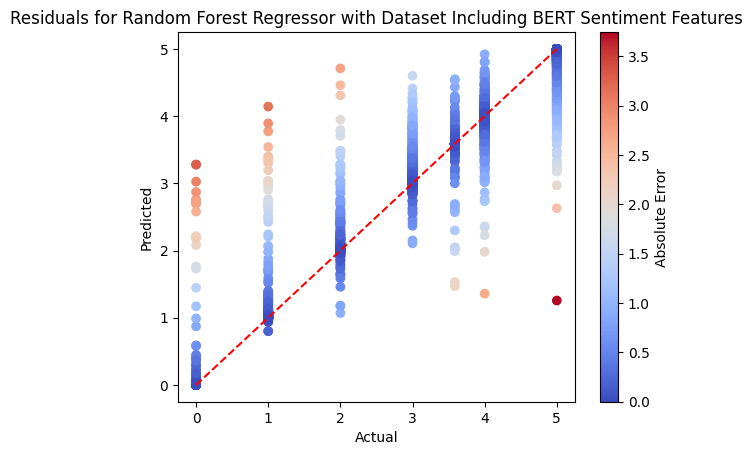

In [89]:
# Example data
errors = y_test - y_pred_bert
error_magnitude = np.abs(errors)

# Scatter plot
plt.scatter(y_test, y_pred_bert, c=error_magnitude, cmap='coolwarm', alpha=1.0)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')  # Ideal line
plt.colorbar(label='Absolute Error')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Residuals for Random Forest Regressor with Dataset Including BERT Sentiment Features")
plt.show()

In [90]:
rf = RandomForestRegressor(n_estimators=100, random_state=123).fit(X_train_bert, y_train)

# Get feature importances
importances = rf.feature_importances_
feature_names = X_train_bert.columns

# Create a DataFrame for better visualization
feat_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(feat_importance)

                   Feature  Importance
18      User rating_scaled    0.195463
7           Website rating    0.182654
17    Comment count_scaled    0.136917
16       Like count_scaled    0.111957
6                  summary    0.098085
0               Movie name    0.077731
8            review_length    0.063521
9        review_word_count    0.053349
20  bert_sentiment_numeric    0.015290
4           original_title    0.013166
19          bert_sentiment    0.010637
10           budget_scaled    0.007159
15       popularity_scaled    0.006795
14       vote_count_scaled    0.006150
12          runtime_scaled    0.005297
11          revenue_scaled    0.005164
5                 overview    0.004814
13     vote_average_scaled    0.004195
3        original_language    0.001129
2                    adult    0.000281
1                   status    0.000247


In [91]:
# VALIDATING MODEL

rf = RandomForestRegressor(n_estimators=100, random_state=123)

cross_val_5 = cross_validate(rf, X_bert, y, cv = 5, scoring = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'r2'])

print("CROSS VALIDATION METRICS FOR 5-FOLD:")
print("Mean Absolute Error: ", -cross_val_5['test_neg_mean_absolute_error'].mean())
print("Mean Squared Error: ", -cross_val_5['test_neg_mean_squared_error'].mean())
print("R2: ", cross_val_5['test_r2'].mean())
print()
print()

cross_val_10 = cross_validate(rf, X_bert, y, cv = 10, scoring = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'r2'])

print("CROSS VALIDATION METRICS FOR 10-FOLD:")
print("Mean Absolute Error: ", -cross_val_10['test_neg_mean_absolute_error'].mean())
print("Mean Squared Error: ", -cross_val_10['test_neg_mean_squared_error'].mean())
print("R2: ", cross_val_10['test_r2'].mean())


CROSS VALIDATION METRICS FOR 5-FOLD:
Mean Absolute Error:  0.13855498620938891
Mean Squared Error:  0.13304661471313842
R2:  0.8987724375698383


CROSS VALIDATION METRICS FOR 10-FOLD:
Mean Absolute Error:  0.1286571095710019
Mean Squared Error:  0.12414696116460266
R2:  0.906343877095901


# CHECKING CORRELATION BETWEEN BERT AND VADER

In [92]:
correlation = merged[['bert_sentiment_numeric', 'vader_score']].corr().iloc[0,1]
print(f"Correlation between BERT and VADER scores: {correlation:.2f}")

Correlation between BERT and VADER scores: 0.18


# MODELING, EVALUATING, AND VALIDATION USING BERT- XGBOOST

In [93]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score
)
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb



# def report funcs

def regression_report(y_true, y_pred):
    mse  = mean_squared_error(y_true, y_pred)
    return {
        "MAE" : mean_absolute_error(y_true, y_pred),
        "MSE" : mse,
        "RMSE": np.sqrt(mse),
        "R2"  : r2_score(y_true, y_pred)
    }

def cv_report(model, X, y, cv):
    scoring = {
        "MAE": "neg_mean_absolute_error",
        "MSE": "neg_mean_squared_error",
        "R2" : "r2"
    }
    cv_res = cross_validate(model, X, y, cv=cv, scoring=scoring,
                            n_jobs=-1, return_train_score=False)
    mae  = -cv_res["test_MAE"].mean()
    mse  = -cv_res["test_MSE"].mean()
    rmse = np.sqrt(mse)
    r2   =  cv_res["test_R2"].mean()
    return {"MAE": mae, "MSE": mse, "RMSE": rmse, "R2": r2}

cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv10 = KFold(n_splits=10, shuffle=True, random_state=42)
top_k     = 15
rnd_state = 42


# XGBoost regressor

xgb_model = xgb.XGBRegressor(
    random_state=rnd_state,
    objective="reg:squarederror",
    n_estimators=500, #CHANGED FROM 300 TO 500
    learning_rate=0.05,
    max_depth=10 # CHANGED FROM 6 TO 10
)

# New subset with only numeric
X_bert_numeric = X_bert.loc[:, ['Movie name', 'status', 'adult', 'original_language', 'Website rating', 'review_length', 'review_word_count', 'budget_scaled', 'revenue_scaled', 'runtime_scaled', 'vote_average_scaled', 'vote_count_scaled', 'popularity_scaled', 'Like count_scaled', 'Comment count_scaled', 'User rating_scaled', 'bert_sentiment', 'bert_sentiment_numeric']]
# Convert 'object' columns to numerical using Label Encoding
label_encoder = LabelEncoder()
for col in ['Movie name', 'bert_sentiment']:
    X_bert_numeric[col] = label_encoder.fit_transform(X_bert_numeric[col].astype(str))

X_train_bert_xg, X_test_bert_xg, y_train, y_test = train_test_split(X_bert_numeric,y, test_size = 0.3, random_state = 234)



xgb_model.fit(X_train_bert_xg, y_train)

xgb_train_pred = xgb_model.predict(X_train_bert_xg)
xgb_test_pred  = xgb_model.predict(X_test_bert_xg)

xgb_metrics_train = regression_report(y_train, xgb_train_pred)
xgb_metrics_test  = regression_report(y_test,  xgb_test_pred)
xgb_metrics_cv    = cv_report(xgb_model, X_bert_numeric, y, cv)
xgb_metrics_cv10    = cv_report(xgb_model, X_bert_numeric, y, cv10)

xgb_imp = (
    pd.Series(xgb_model.feature_importances_, index=X_bert_numeric.columns)
      .sort_values(ascending=False)
      .head(top_k)
)


# results

print("\n=== XGBoost Metrics ===")
print("Train :", xgb_metrics_train)
print("Test  :", xgb_metrics_test)
print("CV(5) :", xgb_metrics_cv)

print("\nTop‑{} XGB feature importances:".format(top_k))
print(xgb_imp.to_string(float_format="%.4f"))

y_pred_xg_bert = xgb_model.predict(X_test_bert_xg)
residuals_xg = y_test - y_pred_xg_bert



=== XGBoost Metrics ===
Train : {'MAE': 0.026594238334979033, 'MSE': 0.004329869438706178, 'RMSE': np.float64(0.0658017434321172), 'R2': 0.996635247382003}
Test  : {'MAE': 0.1289535969611888, 'MSE': 0.12022860467308978, 'RMSE': np.float64(0.34673996693933307), 'R2': 0.9095615244608056}
CV(5) : {'MAE': np.float64(0.1254877783244605), 'MSE': np.float64(0.11676292442797054), 'RMSE': np.float64(0.3417059034139892), 'R2': np.float64(0.9102347907255078)}

Top‑15 XGB feature importances:
User rating_scaled       0.2625
Website rating           0.1450
Comment count_scaled     0.1121
bert_sentiment_numeric   0.0911
review_word_count        0.0758
Like count_scaled        0.0704
bert_sentiment           0.0592
Movie name               0.0578
review_length            0.0479
revenue_scaled           0.0139
vote_count_scaled        0.0133
budget_scaled            0.0130
vote_average_scaled      0.0124
popularity_scaled        0.0117
runtime_scaled           0.0070


# Plotting Residuals for XGBoost

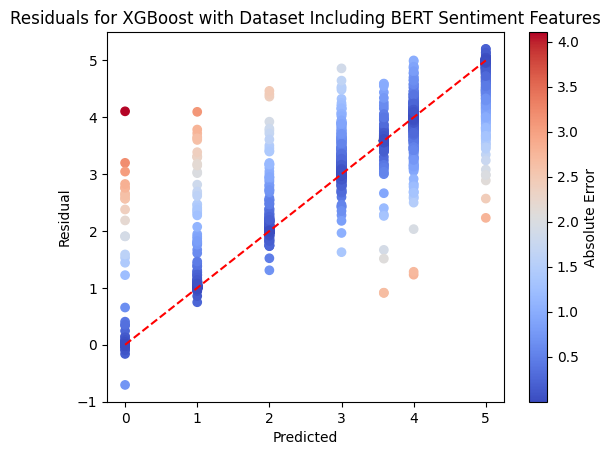

In [94]:
error_magnitude_xg = np.abs(residuals_xg)
plt.scatter(y_test, y_pred_xg_bert, c=error_magnitude_xg, cmap='coolwarm',
alpha=1.0)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.colorbar(label='Absolute Error')
plt.xlabel("Predicted")
plt.ylabel("Residual")
plt.title("Residuals for XGBoost with Dataset Including BERT Sentiment Features")
plt.show()

# **0.1.7. Issues / Improvements**
1. Character symbols such as emojis could not be analyzed in sentiment analysis. These instances were removed
2. ftfy did now fix encoding issues for all movie rating scores on the 5 star scale. Manual replacements were performed.
3. Release year and release data not compatible with our models. These were removed as we did not perform a time series model.
4. Rating_x caused errors even after imputing "No Rating." This issue couldn't be resolved and was removed in the meantime while performing modeling. With the performance metrics we obtained, we left this feature out of the dataset.




# **0.1.8. References**


*   Ali, Muhammad, P. J. “Investigating the Impact of Min-Max Data Normalization on the
Regression Performance of K-Nearest Neighbor With Different Similarity Measurements”. ARO-THE SCIENTIFIC JOURNAL OF KOYA UNIVERSITY, Vol. 10, no.
1, June 2022, pp. 85-91, doi:10.14500/aro.10955.
*   Chen, Tianqu, and C. Guestrin. XGBoost: A Scalable Tree Boosting System. 2016, arXiv,
https://arxiv.org/abs/1603.02754.
*   Doz, D., Mara Cotič, and Darjo Felda. “Random Forest Regression in Predicting Students’
Achievements and Fuzzy Grades.” Mathematics, vol. 11, no. 19, 2023, p. 4129,
https://doi.org/10.3390/math11194129.



